In [1]:
%load_ext autoreload
%autoreload 2
from utils.all import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
import numpy as np

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
train_targets.shape, train_targets[:5]

((404,), array([15.2, 42.3, 50. , 21.1, 17.7]))

feature wise normalization - input normalization is important for neural networks but you wouldn't want to do this if you were training a random forest

In [5]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data, test_data = [(d-mean)/std for d in [train_data, test_data]]

Our `build_model` function tries one little thing that is not in the book - at the end of this notebook, we try limiting the range of outputs - like [fastai](https://docs.fast.ai/layers.html#sigmoid_range)

In [6]:
def build_model(final_activation=None):
    if final_activation is None:
        final_layer = keras.layers.Dense(1)
        print('Building model with no final activation')
    else:
        print('Building model with final_activation', final_activation)
        final_layer = keras.layers.Dense(1, activation=final_activation)
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        final_layer
    ])
    model.compile(
        optimizer='rmsprop',
        loss=keras.losses.mean_squared_error,
        metrics=['mae']
    )
    return model

quick training run to see if our model is working

In [7]:
model = build_model()
history = model.fit(
    train_data,
    train_targets,
    batch_size=64,
    epochs=20,
    validation_data=(test_data, test_targets)
)

Building model with no final activation
Epoch 1/20
7/7 [==============================] - 1s 48ms/step - loss: 562.4833 - mae: 21.8377 - val_loss: 560.8290 - val_mae: 21.8453
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 517.9554 - mae: 20.7765 - val_loss: 517.4431 - val_mae: 20.7989
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 475.0397 - mae: 19.6784 - val_loss: 469.2574 - val_mae: 19.5845
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 427.5328 - mae: 18.4391 - val_loss: 415.5553 - val_mae: 18.2174
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 376.0263 - mae: 17.0673 - val_loss: 362.2380 - val_mae: 16.8615
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 324.2310 - mae: 15.6398 - val_loss: 307.8140 - val_mae: 15.4814
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 272.2942 - mae: 14.1223 - val_loss: 254.7739 - val_mae: 14.0354
Epoch 8/20
7/7 [=====

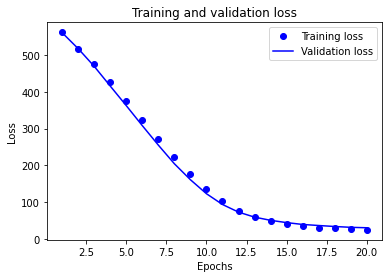

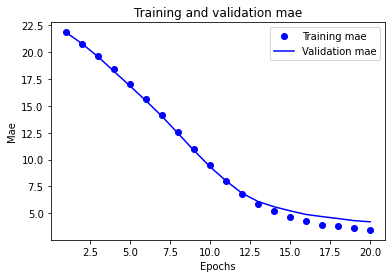

In [8]:
plot_history(history)

In [9]:
print('model was out by $', history.history['mae'][-1]*1000, 'on test data')

model was out by $ 3459.2738151550293 on test data


k-fold validation

In [10]:
k = 4
n_epochs = 250
bs = 16

In [11]:
def fold_split(fold, data):
    fold_size = len(data)//k
    val = data[fold*fold_size:(fold+1)*fold_size]
    train = np.concatenate([data[:fold*fold_size], data[(fold+1)*fold_size:]], axis=0)
    return train, val

In [12]:
assert 2==len(fold_split(1, train_targets))
t, v = fold_split(1, train_data)
assert (303, 13)==t.shape
assert (101, 13)==v.shape

In [13]:
scores = []
mae_histories = []
histories = []
models = []
for fold in range(k):
    print('Processing fold', fold)
    td, vd = fold_split(fold, train_data)
    tt, vt = fold_split(fold, train_targets)
    model = build_model()
    models.append(model)
    history = model.fit(td, tt, epochs=n_epochs, batch_size=bs, verbose=0, validation_data=[vd, vt])
    histories.append(history)
    val_mse, val_mae = model.evaluate(vd, vt)
    scores.append(val_mae)
    mae_histories.append(history.history['val_mae'])

Processing fold 0
Building model with no final activation
4/4 [==============================] - 0s 2ms/step - loss: 8.3650 - mae: 2.0581
Processing fold 1
Building model with no final activation
4/4 [==============================] - 0s 2ms/step - loss: 15.1356 - mae: 2.7630
Processing fold 2
Building model with no final activation
4/4 [==============================] - 0s 1ms/step - loss: 15.2392 - mae: 2.5936
Processing fold 3
Building model with no final activation
4/4 [==============================] - 0s 2ms/step - loss: 12.1495 - mae: 2.4704


In [14]:
print('mean final validation mae', np.mean(scores))

mean final validation mae 2.471269905567169


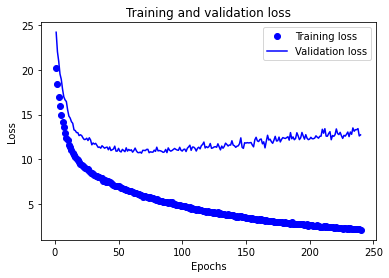

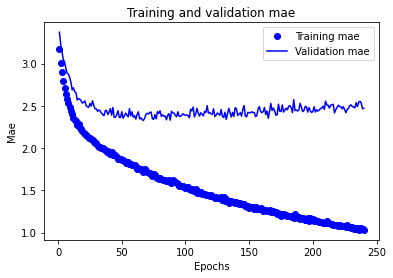

In [15]:
mean_histories = {}
for k in histories[0].history.keys():
    mean_histories[k] = np.array([history.history[k] for history in histories]).mean(axis=0)

plot_history(mean_histories, ignore_first_n=10)

evaluate each model

In [22]:
for m in models:
    m.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.2426 - mae: 2.8529


if we want to calculate mae ourselves, we need to squeeze preds from (414,1) to (404,) to match target shape

In [23]:
tf.reduce_mean(keras.losses.mean_absolute_error(test_targets, model.predict(test_data).squeeze()))

<tf.Tensor: shape=(), dtype=float32, numpy=2.85287>

cheeky ensemble gives us a better result than any single model but ... can we train a single model that will do better?

In [24]:
all_preds = [m.predict(test_data) for m in models]
mean_preds = np.array(all_preds).mean(axis=0).squeeze()
tf.reduce_mean(keras.losses.mae(test_targets, mean_preds))

<tf.Tensor: shape=(), dtype=float32, numpy=2.349578>

see if we can get a better result by not training for too many epochs

In [41]:
model = build_model()
history = model.fit(train_data, train_targets, epochs=120, batch_size=16, verbose=0, validation_data=[test_data, test_targets])
model.evaluate(test_data, test_targets)

Building model with no final activation
4/4 [==============================] - 0s 2ms/step - loss: 18.1820 - mae: 2.7819


[18.18196678161621, 2.781907558441162]

&uarr; not much better than most of the over-fit models ...

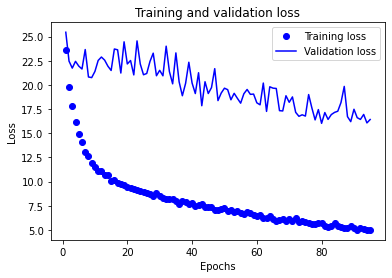

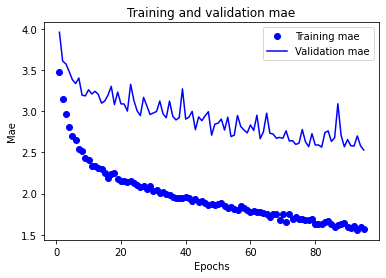

In [33]:
plot_history(history, ignore_first_n=5)

&uarr; quite bumpy but still trending downwards

&darr; can we help the model by resticting the range of output values to be a bit wider than the min/max targets?

In [35]:
test_targets.min(), train_targets.max()

(5.6, 50.0)

In [36]:
def sigmoid_range(x):
    "Force output to be between 0 and 60"
    return keras.activations.sigmoid(x) * 60.0

In [39]:
model = build_model(sigmoid_range)
history = model.fit(train_data, train_targets, epochs=120, batch_size=16, verbose=0, validation_data=[test_data, test_targets])
model.evaluate(test_data, test_targets)

Building model with final_activation <function sigmoid_range at 0x000002B295B9D8B0>
4/4 [==============================] - 0s 2ms/step - loss: 11.4042 - mae: 2.2182


[11.404191970825195, 2.2182304859161377]

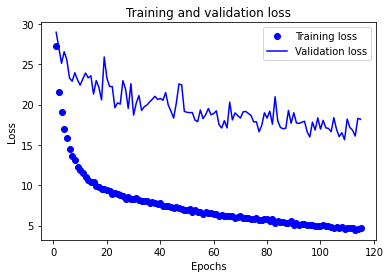

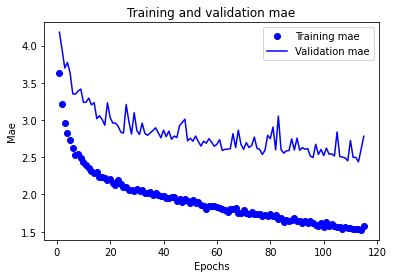

In [42]:
plot_history(history, 5)

This seems to help (o: but ... not every run ends up this low